In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
import optuna

from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

c:\Users\14390\.conda\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
features = np.load(f'DataSet/Features_Diff_1.npz')['Features_Diff_1']
print(features.shape)

(151839, 71, 9)


In [4]:
data = features[0:90000]

In [5]:
input_window = 47
output_window = 24

# 用来存储输入和输出的列表
inputs = []
outputs = []

# 为了确保没有超出数组的界限，我们创建一个循环，截止到可以完整提取一个输入加一个输出的位置
for i in range(data.shape[1] - input_window - output_window + 1):
    # 对每一个样本处理
    for sample in data:
        inputs.append(sample[i:i + input_window])
        outputs.append(sample[i + input_window: i + input_window + output_window])

inputs = np.array(inputs)
outputs = np.array(outputs)

# 转换为torch.Tensor
inputs_tensor = torch.from_numpy(inputs).float()
outputs_tensor = torch.from_numpy(outputs).float()

# 划分训练集和测试集
num_samples = inputs_tensor.shape[0]
train_size = int(num_samples * 0.8)

train_inputs = inputs_tensor[:train_size]
train_outputs = outputs_tensor[:train_size]
test_inputs = inputs_tensor[train_size:]
test_outputs = outputs_tensor[train_size:]

# 创建数据集和数据加载器
train_dataset = TensorDataset(train_inputs, train_outputs)
train_loader = DataLoader(train_dataset, batch_size=36, shuffle=True, num_workers=16, pin_memory=True)

test_dataset = TensorDataset(test_inputs, test_outputs)
test_loader = DataLoader(test_dataset, batch_size=36, shuffle=False, num_workers=16, pin_memory=True)

# 验证输出形状
print("Train inputs shape:", train_inputs.shape)
print("Train outputs shape:", train_outputs.shape)
print("Test inputs shape:", test_inputs.shape)
print("Test outputs shape:", test_outputs.shape)

Train inputs shape: torch.Size([72000, 47, 9])
Train outputs shape: torch.Size([72000, 24, 9])
Test inputs shape: torch.Size([18000, 47, 9])
Test outputs shape: torch.Size([18000, 24, 9])


In [21]:
class GatedLinearUnit(nn.Module):
    def __init__(self, input_size):
        super(GatedLinearUnit, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.fc2 = nn.Linear(input_size, input_size)

    def forward(self, x):
        return self.fc1(x) * torch.sigmoid(self.fc2(x))

class TemporalFusionTransformer(nn.Module):
    def __init__(self, num_features, hidden_size, num_outputs):
        super(TemporalFusionTransformer, self).__init__()
        self.hidden_size = hidden_size
        
        # 输入编码
        self.input_layer = nn.Linear(num_features, hidden_size)
        
        # 自注意力层
        self.attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=8, batch_first=True)
        
        # GLU 层
        self.glu = GatedLinearUnit(hidden_size)
        
        # 输出层
        self.output_layer = nn.Linear(hidden_size, num_outputs)

    def forward(self, x):
        # 输入编码
        x_encoded = F.relu(self.input_layer(x))
        
        # 自注意力
        attn_output, _ = self.attention(x_encoded, x_encoded, x_encoded)
        
        # GLU
        x_glu = self.glu(attn_output)
        print(x_glu.shape)
        # 输出
        output = self.output_layer(x_glu)
        return output


In [2]:
import torch
import torch.nn as nn

class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features):
        super(GraphConvolution, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x, edge_index):
        # For simplicity, assuming edge_index is unused in this simplified example
        return self.fc(x)

class TemporalConvolutionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(TemporalConvolutionLayer, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size//2)

    def forward(self, x):
        return self.conv(x)

class GraphWaveNet(nn.Module):
    def __init__(self, num_nodes=9, num_features=8, temporal_kernel_size=2):
        super(GraphWaveNet, self).__init__()
        # Graph convolutions
        self.graph_conv1 = GraphConvolution(num_features, 16)
        self.graph_conv2 = GraphConvolution(16, 32)
        # Temporal convolutions
        self.temporal_conv1 = TemporalConvolutionLayer(num_nodes * 32, 64, temporal_kernel_size)
        self.temporal_conv2 = TemporalConvolutionLayer(64, num_nodes * num_features, temporal_kernel_size)

    def forward(self, x):
        batch_size, num_nodes, num_timesteps, num_features = x.size()
        x = x.permute(0, 2, 1, 3).reshape(batch_size * num_timesteps, num_nodes, num_features)
        x = x.permute(0, 2, 1).reshape(-1, num_features)

        x = self.graph_conv1(x)
        x = self.graph_conv2(x)

        x = x.view(batch_size, num_timesteps, num_nodes * 32).permute(0, 2, 1)

        x = self.temporal_conv1(x)
        x = self.temporal_conv2(x)

        try:
            # Reshape to the expected output shape and permute if needed
            x = x.view(batch_size, num_timesteps, num_nodes, num_features).permute(0, 1, 2, 3)
        except RuntimeError as e:
            print(e)
            print(f"Attempted to reshape tensor of size {x.size()} to {batch_size, num_timesteps, num_nodes, num_features}")

        return x

# Example usage
num_batches = 20
num_nodes = 9
num_timesteps = 24
num_features = 8
x = torch.randn(num_batches, num_nodes, num_timesteps, num_features)

model = GraphWaveNet()

In [3]:
print(model)

GraphWaveNet(
  (graph_conv1): GraphConvolution(
    (fc): Linear(in_features=8, out_features=16, bias=True)
  )
  (graph_conv2): GraphConvolution(
    (fc): Linear(in_features=16, out_features=32, bias=True)
  )
  (temporal_conv1): TemporalConvolutionLayer(
    (conv): Conv1d(288, 64, kernel_size=(2,), stride=(1,), padding=(1,))
  )
  (temporal_conv2): TemporalConvolutionLayer(
    (conv): Conv1d(64, 72, kernel_size=(2,), stride=(1,), padding=(1,))
  )
)


In [22]:
def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=1e-3):
    # 选择设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

    # 训练循环
    model.train()
    for epoch in range(num_epochs):
        total_train_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            print(outputs.shape)
            # 计算损失
            loss = criterion(outputs, targets)
            # clip_grad_norm_(model.parameters(), max_norm=0.1)  # Gradient clipping
            total_train_loss += loss.item()
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # 计算平均训练损失
        avg_train_loss = total_train_loss / len(train_loader)
        
        # 在测试集上评估模型
        model.eval()  # 设置模型为评估模式
        total_test_loss = 0
        with torch.no_grad():  # 关闭梯度计算
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        scheduler.step()
        # scheduler.step(avg_test_loss)
        # 打印训练和测试损失
        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')
        model.train()  # 重新设置模型为训练模式


In [23]:
model = TemporalFusionTransformer(num_features=9, hidden_size=128, num_outputs=9)
# for module in model.modules():
#     # if isinstance(module, torch.nn.Linear):  # 你可以选择监控特定类型的层
#     module.register_backward_hook(hook_fn)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(1)

model.apply(init_weights)



# train_model(model, train_loader, test_loader, num_epochs=50, learning_rate=0.01)

TemporalFusionTransformer(
  (input_layer): Linear(in_features=9, out_features=128, bias=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (glu): GatedLinearUnit(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=9, bias=True)
)

In [24]:
train_model(model, train_loader, test_loader, num_epochs=50, learning_rate=0.001)

torch.Size([36, 47, 128])
torch.Size([36, 47, 9])


c:\Users\14390\.conda\envs\torch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([36, 24, 9])) that is different to the input size (torch.Size([36, 47, 9])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (47) must match the size of tensor b (24) at non-singleton dimension 1

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000214DAB8B0A0>
Traceback (most recent call last):
  File "c:\Users\14390\.conda\envs\torch\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\14390\.conda\envs\torch\lib\site-packages\torch\utils\data\dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\Users\14390\.conda\envs\torch\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "c:\Users\14390\.conda\envs\torch\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 
C:\Users\14390\AppData\Local\Temp\ipykernel_29748\3817747172.py:31: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
C:\Users\14390\AppData\Local\Temp\ipykernel_29748\3817747172.py:

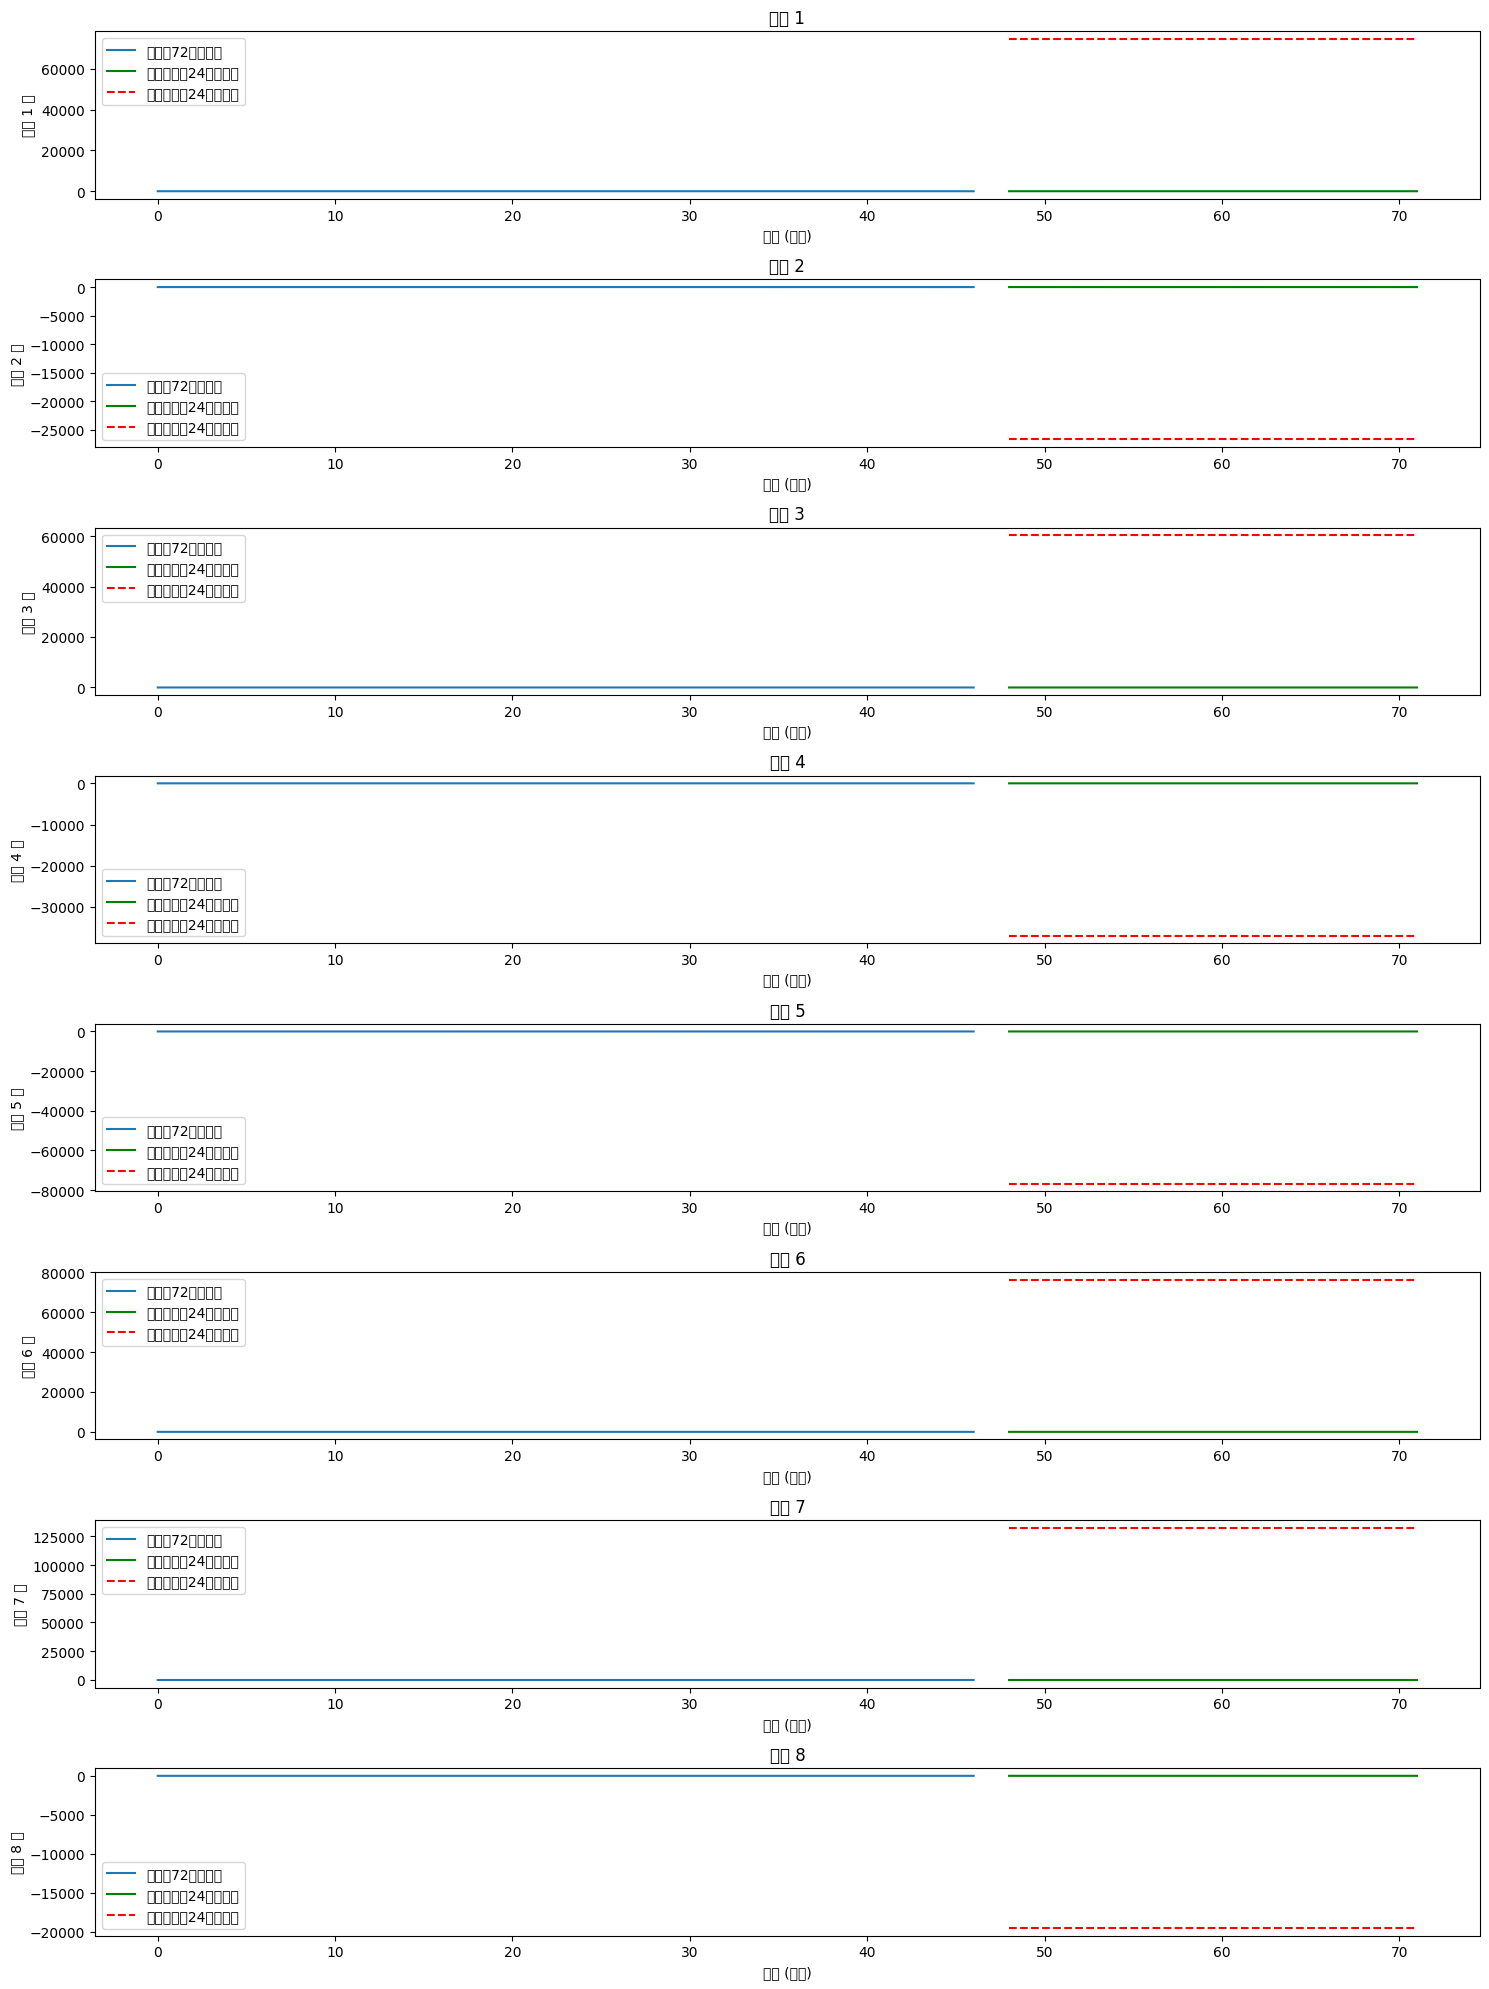

In [ ]:
Num_Feature = 9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate_and_plot_features(model, test_loader):
    for batch in test_loader:
        inputs, targets = batch
        model.to(device)
        output= model(inputs.to(device))
        # 选择第一个样本
        single_input = inputs[0:1].view(1, -1).to(device)
        single_target = targets[0:1].to(device)
        output = output[0:1].to(device)
        break  # 只处理第一个batch
    # 将数据移回CPU以便打印或进一步处理
    single_input = single_input.cpu().view(-1, Num_Feature)  # 假设输入有9个特征
    single_target = single_target.cpu().view(-1, Num_Feature)
    output = output.cpu().view(-1, Num_Feature)

    # 绘制每个特征的图表
    num_features = Num_Feature
    plt.figure(figsize=(15, 20))
    for i in range(num_features):
        plt.subplot(num_features, 1, i+1)
        plt.plot(single_input[:, i], label='真实的72小时数据')
        plt.plot(range(48, 72), single_target[:, i], 'g', label='真实的未来24小时目标')
        plt.plot(range(48, 72), output[:, i].detach().numpy(), 'r--', label='模型预测的24小时数据')
        plt.title(f'特征 {i+1}')
        plt.xlabel('时间 (小时)')
        plt.ylabel(f'特征 {i+1} 值')
        plt.legend()

    plt.tight_layout()
    plt.show()

# 调用函数
evaluate_and_plot_features(model, test_loader)